In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
#Load the data from the web
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')


In [3]:
#Validate dataset loading
if df.empty:
    print("The dataset is empty. Please check the source URL.")
else:
    print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")


Dataset loaded successfully with 541909 rows and 8 columns.


Data cleaning

In [4]:

df['Description'] = df['Description'].str.strip()  # Remove spaces from beginning and end of descriptions
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)  #Remove rows with missing InvoiceNo
df['InvoiceNo'] = df['InvoiceNo'].astype('str')  #Convert InvoiceNo to string
df = df[~df['InvoiceNo'].str.contains('C')]  #Remove credit transactions
print(f"Dataset after cleaning: {df.shape[0]} rows")

Dataset after cleaning: 532621 rows


In [5]:
#Display the number of transactions per country
print("Transactions by country:")
print(df['Country'].value_counts())

Transactions by country:
Country
United Kingdom          487622
Germany                   9042
France                    8408
EIRE                      7894
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1967
Portugal                  1501
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Unspecified                446
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     295
Hong Kong                  284
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA   

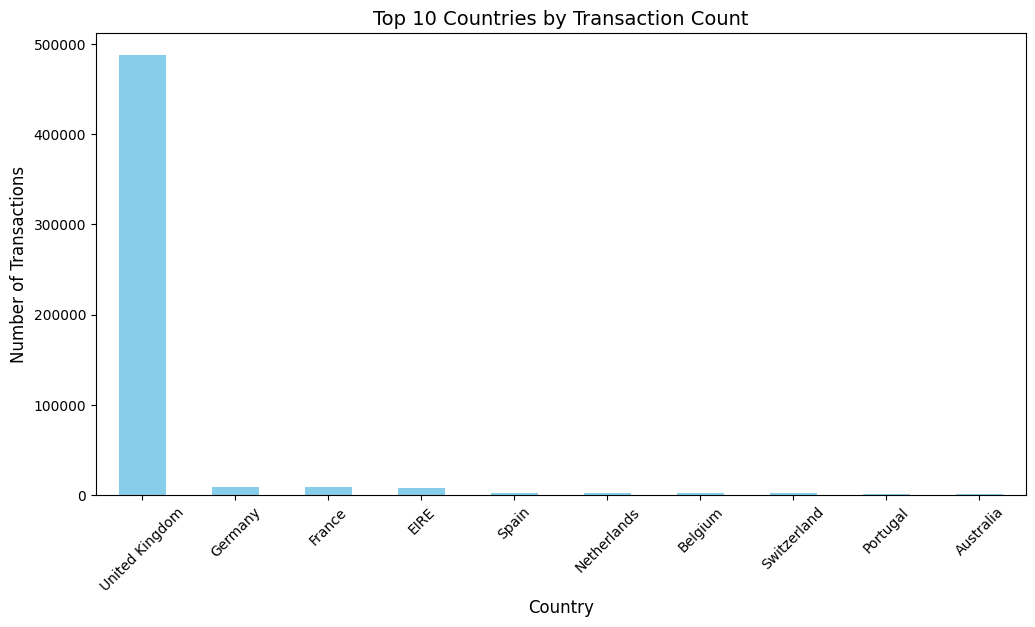

In [6]:
#Plot transactions by country
plt.figure(figsize=(12, 6))
df['Country'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries by Transaction Count', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [7]:
#Filter for transactions in the United Kingdom
uk_basket = (
    df[df['Country'] == "United Kingdom"]
    .groupby(['InvoiceNo', 'Description'])['Quantity']
    .sum()
    .unstack()
    .reset_index()
    .fillna(0)
    .set_index('InvoiceNo')
)
print(f"United Kingdom basket shape: {uk_basket.shape}")

United Kingdom basket shape: (18667, 4175)


In [8]:
#Convert quantities to 1 (purchased) or 0 (not purchased)
uk_basket_encoded = uk_basket.applymap(lambda x: 1 if x >= 1 else 0)

C:\Users\HP\AppData\Local\Temp\ipykernel_11408\991066346.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  uk_basket_encoded = uk_basket.applymap(lambda x: 1 if x >= 1 else 0)


In [9]:
#Drop the "POSTAGE" column if it exists
if 'POSTAGE' in uk_basket_encoded.columns:
    uk_basket_encoded.drop('POSTAGE', inplace=True, axis=1)

In [10]:
#Generate frequent itemsets with a dynamic support threshold
min_support_value = 0.02  
frequent_itemsets = apriori(uk_basket_encoded, min_support=min_support_value, use_colnames=True)


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


C:\Users\HP\AppData\Local\Temp\ipykernel_11408\1539240194.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_itemsets['support'], y=top_itemsets['itemsets'].astype(str), palette='viridis')


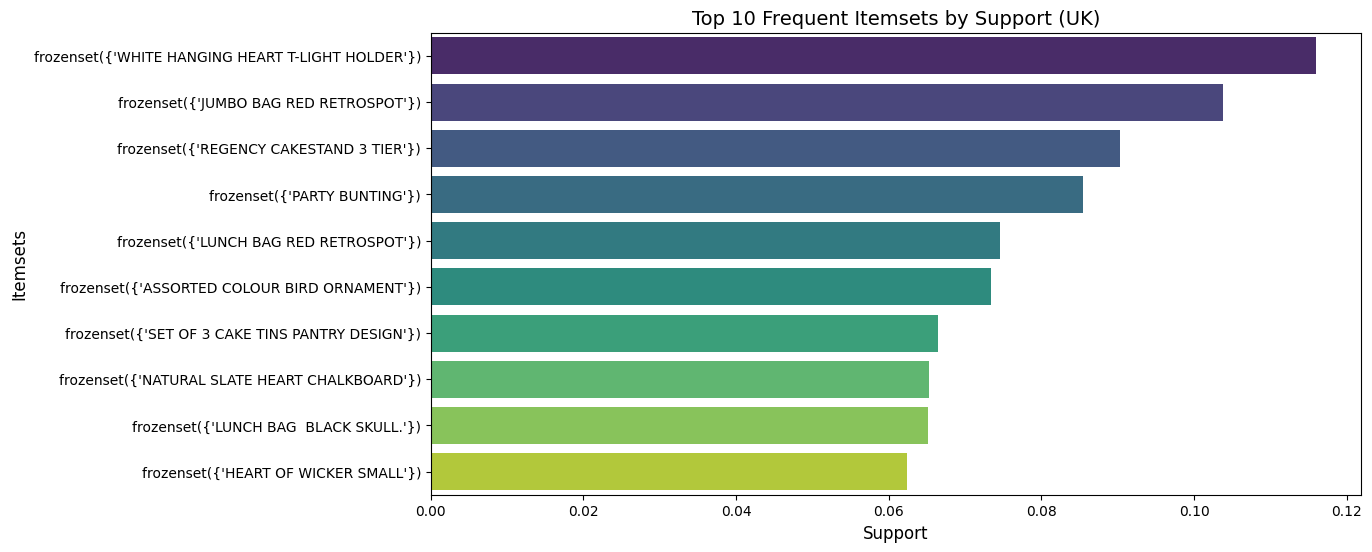

In [11]:
#Plot the top 10 frequent itemsets by support
frequent_itemsets['item_count'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
top_itemsets = frequent_itemsets.nlargest(10, 'support')
plt.figure(figsize=(12, 6))
sns.barplot(x=top_itemsets['support'], y=top_itemsets['itemsets'].astype(str), palette='viridis')
plt.title('Top 10 Frequent Itemsets by Support (UK)', fontsize=14)
plt.xlabel('Support', fontsize=12)
plt.ylabel('Itemsets', fontsize=12)
plt.show()

In [12]:
#Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

C:\Users\HP\AppData\Local\Temp\ipykernel_11408\606251526.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rules['lift'], y=top_rules['antecedents'].astype(str), palette='magma')


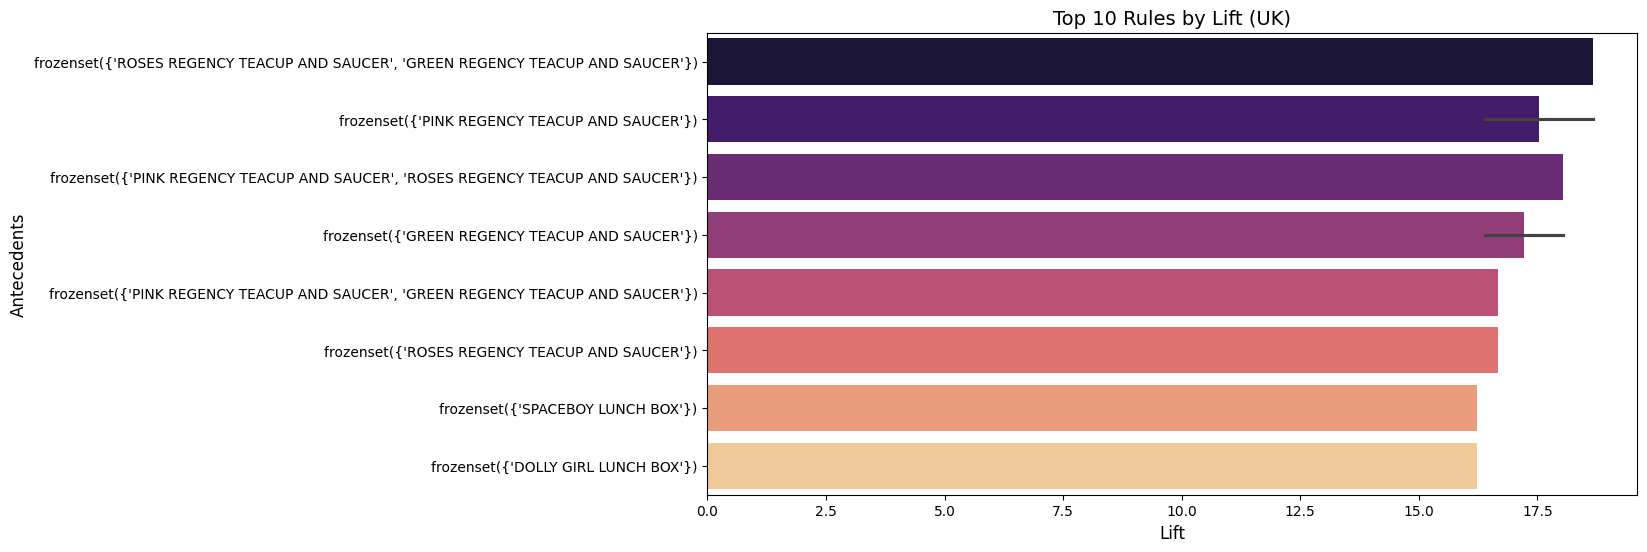

In [13]:
#Plot top 10 rules by lift
top_rules = rules.nlargest(10, 'lift')
plt.figure(figsize=(12, 6))
sns.barplot(x=top_rules['lift'], y=top_rules['antecedents'].astype(str), palette='magma')
plt.title('Top 10 Rules by Lift (UK)', fontsize=14)
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)
plt.show()

In [14]:
#Filter rules based on lift and confidence thresholds
filtered_rules = rules[(rules['lift'] >= 3) & (rules['confidence'] >= 0.3)]
filtered_rules = filtered_rules.sort_values(by='lift', ascending=False)


In [15]:
#Display filtered rules in a user-friendly format
print("\nFiltered rules (lift >= 3, confidence >= 0.3):")
for _, row in filtered_rules.iterrows():
    print(f"Rule: {set(row['antecedents'])} -> {set(row['consequents'])} "
          f"(support={row['support']:.2f}, confidence={row['confidence']:.2f}, lift={row['lift']:.2f})")



Filtered rules (lift >= 3, confidence >= 0.3):
Rule: {'ROSES REGENCY TEACUP AND SAUCER', 'GREEN REGENCY TEACUP AND SAUCER'} -> {'PINK REGENCY TEACUP AND SAUCER'} (support=0.03, confidence=0.70, lift=18.67)
Rule: {'PINK REGENCY TEACUP AND SAUCER'} -> {'ROSES REGENCY TEACUP AND SAUCER', 'GREEN REGENCY TEACUP AND SAUCER'} (support=0.03, confidence=0.70, lift=18.67)
Rule: {'PINK REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER'} -> {'GREEN REGENCY TEACUP AND SAUCER'} (support=0.03, confidence=0.90, lift=18.05)
Rule: {'GREEN REGENCY TEACUP AND SAUCER'} -> {'PINK REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER'} (support=0.03, confidence=0.53, lift=18.05)
Rule: {'PINK REGENCY TEACUP AND SAUCER', 'GREEN REGENCY TEACUP AND SAUCER'} -> {'ROSES REGENCY TEACUP AND SAUCER'} (support=0.03, confidence=0.85, lift=16.67)
Rule: {'ROSES REGENCY TEACUP AND SAUCER'} -> {'PINK REGENCY TEACUP AND SAUCER', 'GREEN REGENCY TEACUP AND SAUCER'} (support=0.03, confidence=0.52, lift=16.67

In [17]:
#Filter rules for high confidence and lift for recommendations
recommendation_rules = rules[(rules['lift'] >= 3) & (rules['confidence'] >= 0.3)]

#Generate recommendations
print("\nProduct Recommendations:")
for _, row in recommendation_rules.iterrows():
    antecedents = ', '.join(list(row['antecedents']))
    consequents = ', '.join(list(row['consequents']))
    print(f"If someone buys [{antecedents}], recommend them [{consequents}].")



Product Recommendations:
If someone buys [60 TEATIME FAIRY CAKE CASES], recommend them [PACK OF 72 RETROSPOT CAKE CASES].
If someone buys [PACK OF 72 RETROSPOT CAKE CASES], recommend them [60 TEATIME FAIRY CAKE CASES].
If someone buys [ALARM CLOCK BAKELIKE GREEN], recommend them [ALARM CLOCK BAKELIKE RED].
If someone buys [ALARM CLOCK BAKELIKE RED], recommend them [ALARM CLOCK BAKELIKE GREEN].
If someone buys [ALARM CLOCK BAKELIKE PINK], recommend them [ALARM CLOCK BAKELIKE RED].
If someone buys [ALARM CLOCK BAKELIKE RED], recommend them [ALARM CLOCK BAKELIKE PINK].
If someone buys [CHARLOTTE BAG PINK POLKADOT], recommend them [CHARLOTTE BAG SUKI DESIGN].
If someone buys [CHARLOTTE BAG SUKI DESIGN], recommend them [CHARLOTTE BAG PINK POLKADOT].
If someone buys [CHARLOTTE BAG PINK POLKADOT], recommend them [RED RETROSPOT CHARLOTTE BAG].
If someone buys [RED RETROSPOT CHARLOTTE BAG], recommend them [CHARLOTTE BAG PINK POLKADOT].
If someone buys [CHARLOTTE BAG SUKI DESIGN], recommend the

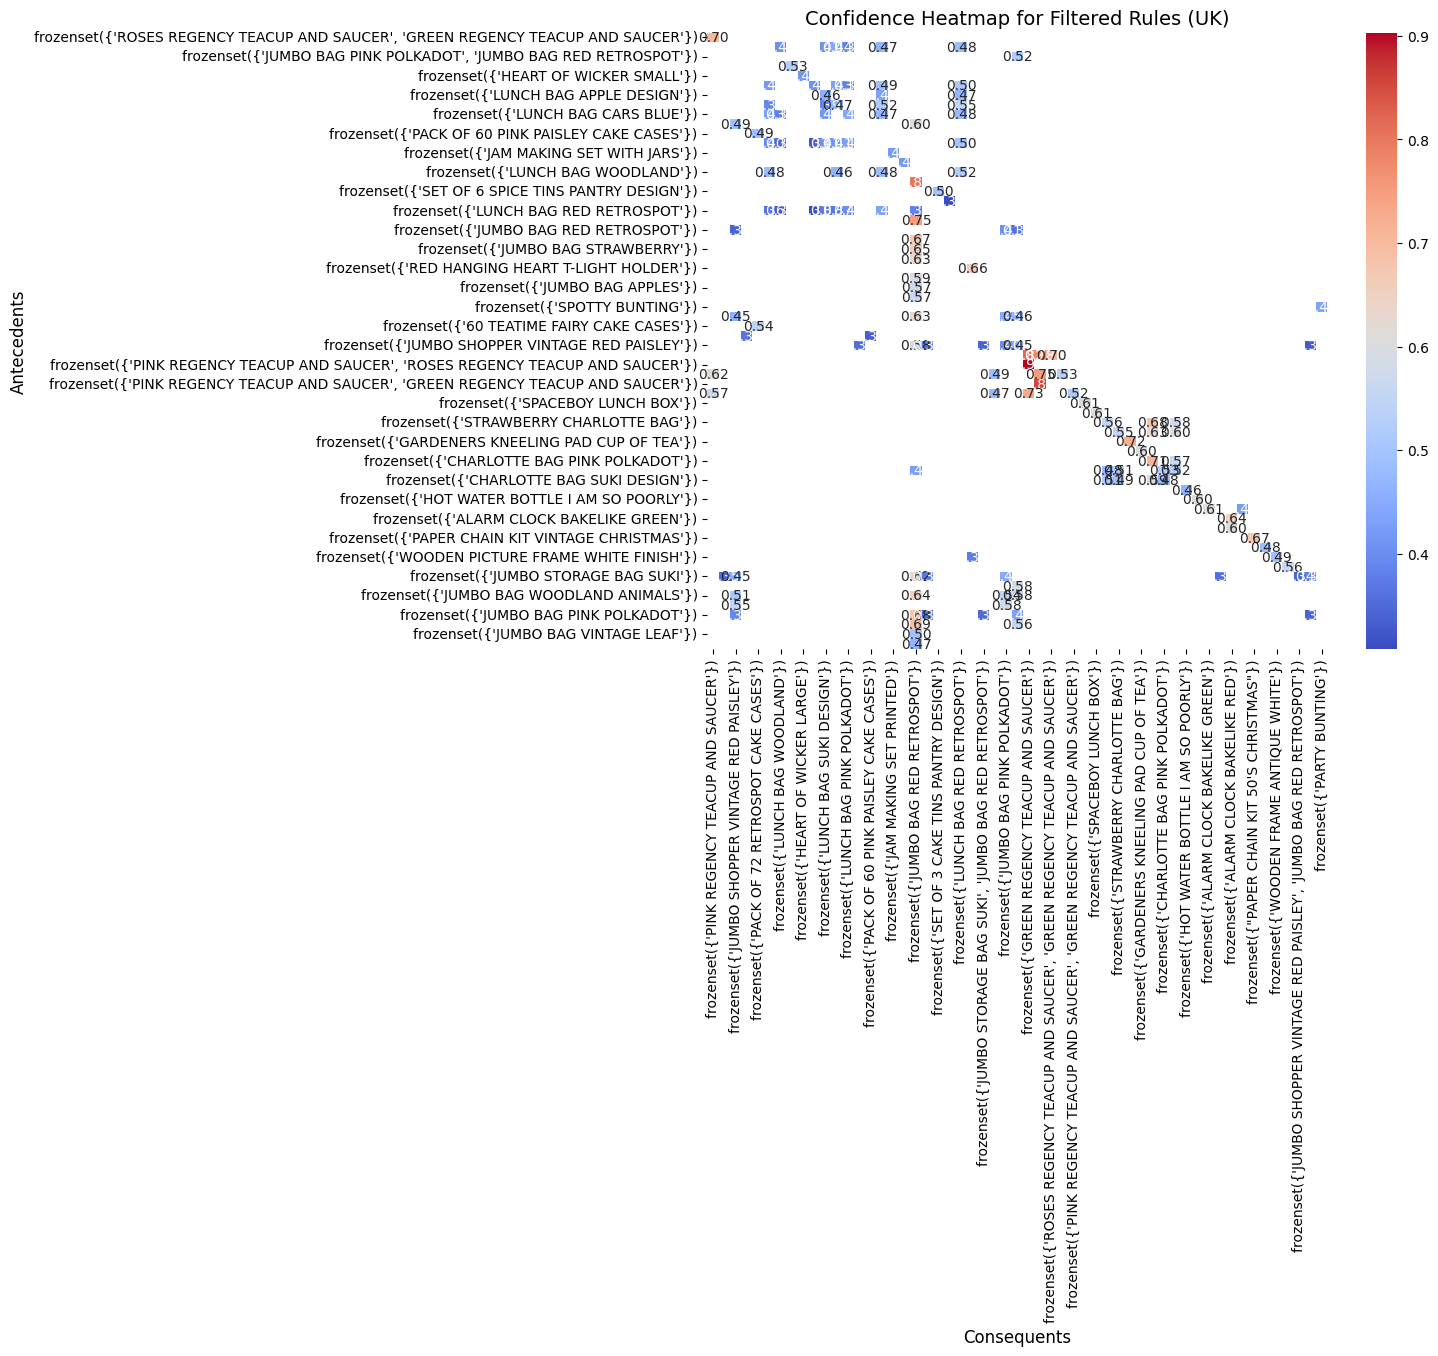

In [18]:
#Heatmap for support vs. confidence of filtered rules
plt.figure(figsize=(10, 8))
sns.heatmap(
    filtered_rules.pivot_table(index='antecedents', columns='consequents', values='confidence'),
    cmap='coolwarm',
    annot=True,
    fmt='.2f'
)
plt.title('Confidence Heatmap for Filtered Rules (UK)', fontsize=14)
plt.ylabel('Antecedents', fontsize=12)
plt.xlabel('Consequents', fontsize=12)
plt.show()